## Machine learning to classify energetic materials

This notebook is based on the tutorial **Your First Machine Learning Project in Python Step-By-Step** (https://machinelearningmastery.com/machine-learning-in-python-step-by-step/), with data from the paper **Applying machine learning techniques to predict the properties of energetic materials** (https://www.nature.com/articles/s41598-018-27344-x).

**If you find any mistakes, please let me know**

### Introduction

A machine learning project may not be linear, but it has a number of well known steps:

- Define Problem.
- Prepare Data.
- Evaluate Algorithms.
- Improve Results.
- Present Results.

The best way to really come to terms with a new platform or tool is to work through a machine learning project end-to-end and cover the key steps. Namely, from loading data, summarizing data, evaluating algorithms and making some predictions.

The goal of this notebook is to present a step-by-step, simple project, that uses machine learning in chemistry. We will:

- Import a dataset with chemical structures and a response variable of interest.
- Calculate chemical descriptors from the structures, using **RDKit**.
- Visualize and summarize information in our dataset, using **Pandas** and **Matplotlib**.
- Generate predictive classification models, using **Scikit-Learn**.
- Estimate the accuracy of our best model using a validation set.


**Note**: this tutorial originally uses the iris dataset. I adapted it to use a more chemical relevant dataset from the paper "Applying machine learning techniques to predict the properties of energetic materials".

Link to download the dataset: https://github.com/delton137/Machine-Learning-Energetic-Molecules-Notebooks/blob/master/datasets/Huang_Massa_data_with_all_SMILES.xlsx

### Packages
If you need help installing Python or packages, please refer to the original tutorial.

In my conda environment, I have already installed the required packages. Several of these come pre-installed on miniconda, but in case you need to install any of them, run this on the environment you are working:

- Matplotlib: conda install -c anaconda matplotlib
- Numpy: conda install -c anaconda numpy
- Pandas: conda install -c anaconda pandas
- Scikit-learn: conda install -c anaconda scikit-learn
- Scipy: conda install -c anaconda scipy
- XLRD (to read .xlsx files): conda install -c anaconda xlrd

In [1]:
# Python version
import sys
print('Python: {}'.format(sys.version))
# matplotlib
import matplotlib
print('matplotlib: {}'.format(matplotlib.__version__))
# numpy
import numpy as np
print('numpy: {}'.format(np.__version__))
# pandas
import pandas as pd
print('pandas: {}'.format(pd.__version__))
# rdkit
import rdkit
print('rdkit: {}'.format(rdkit.__version__))
# scikit-learn (is imported as sklearn)
import sklearn
print('sklearn: {}'.format(sklearn.__version__))

Python: 3.7.7 (default, May  6 2020, 11:45:54) [MSC v.1916 64 bit (AMD64)]
matplotlib: 3.2.1
numpy: 1.18.5
pandas: 1.0.5
rdkit: 2020.03.2
sklearn: 0.23.2


Importing other modules and functions

In [2]:
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
from rdkit import Chem
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

## Importing the dataset and a brief overview

In [3]:
# Importing the dataset
df = pd.read_excel(r"./Huang_Massa_data_with_all_SMILES.xlsx", header=0)
df.head()

,num,Molecular Name,Formula,Density (g/cm3),Delta Hf solid (kj/mol),Explosive energy (kj/cc),Shock velocity (km/s),Particle velocity (km/s),Speed of sound (km/s),Pressure (Gpa),T(K),TNT Equiv (per cc),group,SMILES,NOTE
0,1,CUGCOW,C8N7O14H1,2.024,641.16,6.419,9.569,2.519,7.050,48.777,5440,2.233,Cubane,O=N(=O)C12C3C4(N(=O)=O)C1(N(=O)=O)C1(N(=O)=O)C...,NaN
1,2,PUBMUU02,C6N12O12H6,2.044,430.83,5.623,9.972,2.346,7.626,47.807,3886,1.828,CL20,O=N(=O)N1C2C3N(N(=O)=O)C4C1N(N(=O)=O)C(C(N2N(=...,NaN
2,3,KURT08MO,C4N8O10H4F4,2.028,-151.80,5.290,8.365,2.286,6.079,38.780,4342,1.842,Linear,[H]C([H])(N(N(=O)=O)C([H])([H])C(N(F)F)(N(=O)=...,NaN
3,4,ELUDEV,C4N10O6H2,1.996,657.13,5.228,9.729,2.289,7.441,44.490,3950,1.698,Pyrazole,O=N(=O)NC1=NON=C1N=NC1=NON=C1NN(=O)=O,NaN
4,5,UGUGUY,C8N6O12H2,1.931,593.87,5.188,9.061,2.318,6.743,40.555,5184,1.920,Cubane,O=N(=O)C12C3C4(C1C1(N(=O)=O)C2(N(=O)=O)C3(N(=O...,NaN


In [4]:
# See how many rows and columns there are on the dataset
df.shape

(110, 15)

In [5]:
# Column labels
df.columns

Index(['num', 'Molecular Name', 'Formula', 'Density (g/cm3)',
       'Delta Hf solid (kj/mol)', 'Explosive energy (kj/cc)',
       'Shock velocity (km/s)', 'Particle velocity (km/s)',
       'Speed of sound (km/s)', 'Pressure (Gpa)', 'T(K)', 'TNT Equiv (per cc)',
       'group', 'SMILES', 'NOTE'],
      dtype='object')

Some compounds have comments under the 'NOTE' column and will be removed.

In [6]:
# Keep only the rows that have 'NaN' under the NOTE column
df = df[df['NOTE'].isna()]
df.shape  # 6 compounds removed
# If you want to see the removed compounds, use: removed = df[~df['NOTE'].isna()]

(104, 15)

Let's look at the molecular structure of some compounds in our dataset.

Using the column 'group', we can see some representative compounds from each group.

In [7]:
# There are 10 groups of explosives
sorted(list(df['group'].unique()))

['Butterfly ',
 'CL20 ',
 'Cubane ',
 'HMX ',
 'Ketone ',
 'Linear ',
 'Pyrazole ',
 'RDX ',
 'Ring ',
 'TNT ']

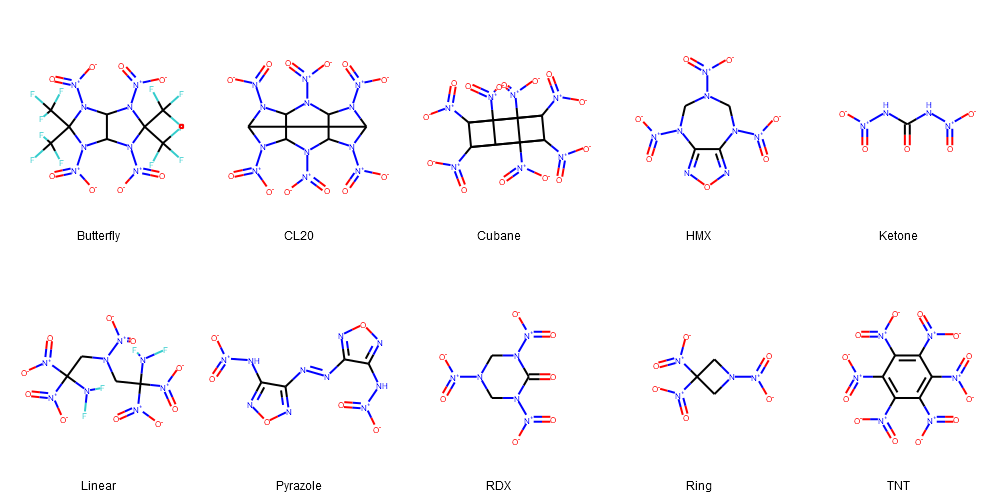

In [8]:
# Selecting the first occurence of each group
cpd_indexes = []
for group in sorted(list(df['group'].unique())):
    for index, row in df.iterrows():
        if row["group"] == group:
            cpd_indexes.append(index)
            break

ms = []
for x in cpd_indexes:
    smi = df['SMILES'].iloc[x]
    ms.append(Chem.MolFromSmiles(smi))

img = Chem.Draw.MolsToGridImage(ms, molsPerRow=5, subImgSize=(200, 250), legends=sorted(list(df['group'].unique())))
img

## Preparing our dataset

To make this problem similar to the one in the tutorial, we will need:
- A categorical target
- Numerical attributes


Therefore, in this notebook, we will try to predict if a molecule is a "strong" explosive (details below) using molecular descriptors.

### Categorical target

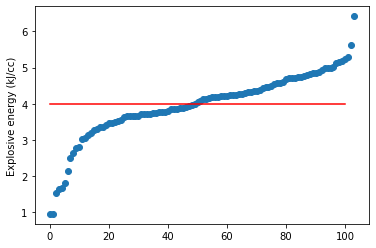

In [9]:
# Visually determine a cutoff for weak/strong explosives
target = df['Explosive energy (kj/cc)'].sort_values()
plt.scatter(range(len(target)), target)
plt.ylabel('Explosive energy (kJ/cc)')
plt.plot([0, 100], [4, 4], c="red")
plt.show()

We will use Explosive energy = 4 kJ/cc as a cutoff to classify our compounds as weak or strong explosives. This is arbitrary and I claim no knowledge about relative explosive strength. I just chose this value because it looks like the graph has an inflection point near 4, and about half the compounds will be on each category).

### Numerical attributes

According to the paper linked above, featurization (selecting the appropriate descriptors) is the most critical part of a ML project with few data points. 

We will use some of the molecular descriptors suggested on the paper:

- Oxygen balance = (100/n atoms) \* (nO - 2\*nC - nH/2)
- Nitrogen/Carbon ratio = (nN/nC)
- Raw counts of C, N, H, F
- Presence of certain chemical groups

The authors used mmltoolkit (https://github.com/delton137/mmltoolkit) to calculate the descriptors. 

We will use SMARTS searches instead. SMARTS are used to describe chemical patterns. To learn more:
https://www.daylight.com/dayhtml_tutorials/languages/smarts/

Several SMARTS can be found at:
https://www.daylight.com/dayhtml_tutorials/languages/smarts/smarts_examples.html


In [10]:
# Function to count the number of matches based on given SMARTS
def count_chemical_group(mol, smarts):
    return len(mol.GetSubstructMatches(Chem.MolFromSmarts(smarts)))


# Oxygen balance 100 as defined on the paper
def oxygen_balance_100(mol):
    mol = Chem.AddHs(mol)
    ob = (100/mol.GetNumAtoms()) * (count_chemical_group(mol, '[#8]') 
                                    - 2*(count_chemical_group(mol, '[#6]')) 
                                    - 0.5*(count_chemical_group(mol, '[#1]')))
    return float("{:.2f}".format(ob))


# Calculate properties for each molecule
x = []

for m in df["SMILES"]:
    mol = Chem.MolFromSmiles(m.strip())  # strip() in case there are empty spaces before/after the string
    mol = Chem.AddHs(mol)
    ob_100 = oxygen_balance_100(mol)
    c = count_chemical_group(mol, '[#6]')
    n = count_chemical_group(mol, '[#7]')
    h = count_chemical_group(mol, '[#1]')
    f = count_chemical_group(mol, '[#9]')
    nc_ratio = float("{:.2f}".format(n/c))
    cnitro = count_chemical_group(mol, '[$([#6]-[NX3](=O)=O),$([#6]-[NX3+](=O)[O-])]')  # C-NO2
    nnitro = count_chemical_group(mol, '[$([#7]-[NX3](=O)=O),$([#7]-[NX3+](=O)[O-])]')  # N-NO2
    onitro = count_chemical_group(mol, '[$([#8]-[NX3](=O)=O),$([#8]-[NX3+](=O)[O-])]')  # O-NO2
    nitrite = count_chemical_group(mol, '[OX2]-[NX2]=[OX1]')  # O-N=O
    cnf = count_chemical_group(mol, '[$([CX3]=[NX2]-[F]),$([CX3]:[NX2]-[F])]')  # C=N-F
    coh = count_chemical_group(mol, '[#6][OX2H]')  # C-O-H, includes phenol
    n_oxide_o = count_chemical_group(mol, '[$([#7+][OX2][#6]);!$([#7](~[O])~[O]);!$([#7]=[#7])]')  # N-O-C
        # Won't hit azoxy, nitro, nitroso, or nitrate.
    fulminate = count_chemical_group(mol, '[#6]=[NX2]-[OX1]')  # C=N-O
    azo = count_chemical_group(mol, '[#6]-[NX2]=[NX2]')  # C-N=N
    amine = count_chemical_group(mol, '[NX3;H2;!$(NC=[!#6]);!$(NC#[!#6])][#6]')  # C-NH2
    n_oxide_n = count_chemical_group(mol, '[C][N+]([O-])([C])[C]') 
        # Paper defines this group as C-N(-O)-C, I believe it is '[C][N+]([O-])([C])[C]'
    cf = count_chemical_group(mol, '[#6]-[F]')  # C-F
    nitroso = count_chemical_group(mol, '[NX2]=[OX1]')  # N=O
    carbonyl = count_chemical_group(mol, '[CX3]=[OX1]')  # C=O
    
    descriptors = [ob_100, c, n, h, f, nc_ratio, cnitro, nnitro, onitro, nitrite, cnf, coh, 
                   n_oxide_o, fulminate, azo, amine, n_oxide_n, cf, nitroso, carbonyl]
    x.append(descriptors)



### Scaling
Before we can proceed, we have to be sure that the ranges of values for each attribute can be compared. For example, we can't have one column with values ranging from 0 to 100 and another with values ranging from 0 to 1.

Therefore, we need to perform scaling or standardization. We will use sklearn.StandardScaler, which scales data to zero mean and unit variance.

In [11]:
# Create dataframe with attributes before scaling
x = pd.DataFrame(np.array(x), columns=["oxygen_balance_100", "c", "n", "h", "f", "nc_ratio", 
                                       "cnitro", "nnitro", "onitro", "nitrite", "cnf", 
                                       "coh", "n_oxide_o", "fulminate", "azo", "amine", 
                                       "n_oxide_n", "cf", "nitroso", "carbonyl"])
x

,oxygen_balance_100,c,n,h,f,nc_ratio,cnitro,nnitro,onitro,nitrite,cnf,coh,n_oxide_o,fulminate,azo,amine,n_oxide_n,cf,nitroso,carbonyl
0,-8.33,8.0,7.0,1.0,0.0,0.88,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-8.33,6.0,12.0,6.0,0.0,2.00,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.00,4.0,8.0,4.0,4.0,2.00,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-13.64,4.0,10.0,2.0,0.0,2.50,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0
4,-17.86,8.0,6.0,2.0,0.0,0.75,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99,-77.14,12.0,2.0,16.0,0.0,0.17,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100,-42.31,2.0,5.0,5.0,0.0,2.50,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0
101,-50.00,4.0,6.0,2.0,0.0,1.50,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
102,-50.00,4.0,6.0,2.0,0.0,1.50,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [12]:
# Scaling
from sklearn.preprocessing import StandardScaler

X = pd.DataFrame(StandardScaler().fit_transform(x), columns=["oxygen_balance_100", "c", "n", "h", "f", "nc_ratio", 
                                       "cnitro", "nnitro", "onitro", "nitrite", "cnf", 
                                       "coh", "n_oxide_o", "fulminate", "azo", "amine", 
                                       "n_oxide_n", "cf", "nitroso", "carbonyl"])

### Categorization of target
Finally, we need to categorize our target column. Every value with Explosive energy > 4 kJ/cc will be assigned the value 1 and categorized as a strong explosive, while values below 4 kJ/cc will be assigned 0.

To achieve this, we will use Pandas boolean logic to assign True/False based on the condition Explosive energy > 4, then convert these booleans to integers simply changing the type of the array (Python converts False to 0 and True to 1).

In [13]:
y = df["Explosive energy (kj/cc)"] > 4
y = y.to_frame()
y.rename(columns={"Explosive energy (kj/cc)":"Strong_explosive"}, inplace = True)
Y = y.astype(int)

### Looking at our dataset
Now that our dataset is similar to the one used in the tutorial, we will proceed as suggested. Let's take a look at:
- First rows of each dataset.
- Dimensions of the dataset.
- Peek at the data itself.
- Statistical summary of all attributes.
- Breakdown of the data by the class variable.

In [14]:
# First rows of our scaled descriptors dataset (X)
X.head(10)

,oxygen_balance_100,c,n,h,f,nc_ratio,cnitro,nnitro,onitro,nitrite,cnf,coh,n_oxide_o,fulminate,azo,amine,n_oxide_n,cf,nitroso,carbonyl
0,0.561462,1.054682,0.220151,-1.338662,-0.398958,-0.625440,3.031064,-0.762365,-0.194461,0.0,0.0,-0.132712,0.0,0.0,-0.2,-0.228086,0.0,-0.291920,-0.098533,-0.454118
1,0.561462,0.245184,2.008878,0.405960,-0.398958,0.521102,-0.937667,3.169168,-0.194461,0.0,0.0,-0.132712,0.0,0.0,-0.2,-0.228086,0.0,-0.291920,-0.098533,-0.454118
2,0.921407,-0.564313,0.577897,-0.291889,1.938600,0.521102,0.196256,-0.107109,-0.194461,0.0,0.0,-0.132712,0.0,0.0,-0.2,-0.228086,0.0,-0.291920,-0.098533,-0.454118
3,0.332012,-0.564313,1.293387,-0.989738,-0.398958,1.032950,-0.937667,0.548146,-0.194461,0.0,0.0,-0.132712,0.0,0.0,5.0,-0.228086,0.0,-0.291920,-0.098533,-0.454118
4,0.149663,1.054682,-0.137594,-0.989738,-0.398958,-0.758521,2.464103,-0.762365,-0.194461,0.0,0.0,-0.132712,0.0,0.0,-0.2,-0.228086,0.0,-0.291920,-0.098533,-0.454118
5,-0.101824,1.054682,0.577897,-0.989738,6.613716,-0.502596,-0.937667,1.858657,-0.194461,0.0,0.0,-0.132712,0.0,0.0,-0.2,-0.228086,0.0,8.382279,-0.098533,-0.454118
6,0.921407,1.054682,0.577897,-1.687587,-0.398958,-0.502596,3.598026,-0.762365,-0.194461,0.0,0.0,-0.132712,0.0,0.0,-0.2,-0.228086,0.0,-0.291920,-0.098533,-0.454118
7,0.601215,-0.159564,-0.495340,-0.291889,1.354210,-0.502596,0.763218,-0.762365,-0.194461,0.0,0.0,-0.132712,0.0,0.0,-0.2,-0.228086,0.0,1.876630,-0.098533,-0.454118
8,0.990977,1.864180,2.724369,1.801658,0.769821,-0.093117,1.330179,0.548146,3.176198,0.0,0.0,-0.132712,0.0,0.0,-0.2,-0.228086,0.0,1.153780,-0.098533,-0.454118
9,0.761527,-0.159564,1.293387,-0.989738,-0.398958,0.521102,0.196256,0.548146,-0.194461,0.0,0.0,-0.132712,0.0,0.0,-0.2,-0.228086,0.0,-0.291920,-0.098533,-0.454118


In [15]:
# Some rows of our responses dataset (Y)
Y.iloc[[0, 1, 2, 3, 4, 54, 55, 56, 57, 58]]

,Strong_explosive
0,1
1,1
2,1
3,1
4,1
54,0
55,0
56,0
57,0
58,0


In [16]:
# Dimensions of X dataset
X.shape

(104, 20)

In [17]:
# Statistical summary of X
print(X.describe())

       oxygen_balance_100             c             n             h  \
count        1.040000e+02  1.040000e+02  1.040000e+02  1.040000e+02   
mean         9.180690e-17  8.540177e-18 -1.579933e-16 -5.124106e-17   
std          1.004843e+00  1.004843e+00  1.004843e+00  1.004843e+00   
min         -4.479938e+00 -1.778560e+00 -2.284067e+00 -1.687587e+00   
25%         -3.390508e-01 -5.643134e-01 -8.530854e-01 -6.408133e-01   
50%          1.753734e-01 -1.595645e-01 -1.375944e-01 -2.918888e-01   
75%          6.154750e-01  6.499334e-01  5.778965e-01  4.931914e-01   
max          2.649838e+00  2.673678e+00  3.439860e+00  3.895206e+00   

                  f      nc_ratio        cnitro        nnitro        onitro  \
count  1.040000e+02  1.040000e+02  1.040000e+02  1.040000e+02  1.040000e+02   
mean  -4.270089e-18  2.562053e-17  7.686159e-17 -5.978124e-17  3.416071e-17   
std    1.004843e+00  1.004843e+00  1.004843e+00  1.004843e+00  1.004843e+00   
min   -3.989583e-01 -1.526294e+00 -9.376674e

In [18]:
# Let's see which columns have all repeated values 
zero_var_columns = [col for col in X.columns if len(X[col].unique()) == 1]
print(zero_var_columns)

['nitrite', 'cnf', 'n_oxide_o', 'fulminate', 'n_oxide_n']


In [19]:
# These can be removed, as they won't contribute to the models
X.drop(labels=zero_var_columns, axis=1, inplace=True)

In [20]:
# Class Distribution: how many compounds belong to each class
Y['Strong_explosive'].value_counts()

1    54
0    50
Name: Strong_explosive, dtype: int64

There are 50 "weak" and 54 "strong" explosives.

## Data Visualization

### Univariate Plots

We start with some univariate plots, that is, plots of each individual variable.

Given that the input variables are numeric, we can create box and whisker plots of each.



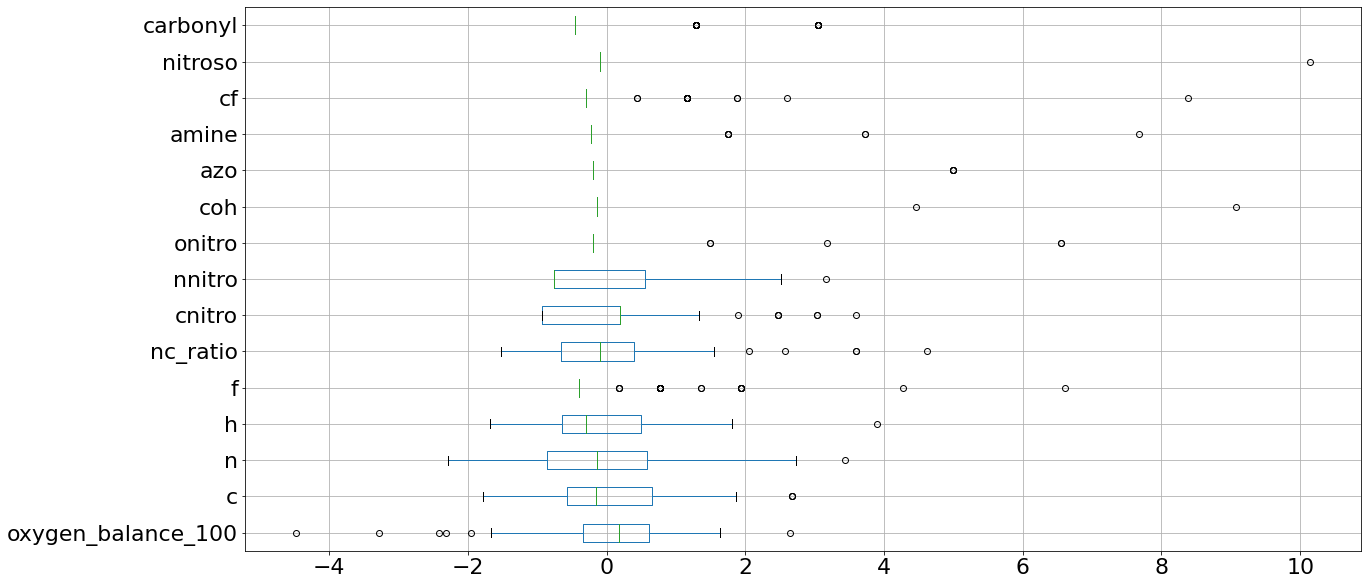

In [21]:
X.boxplot(vert=False, figsize=(20,10), fontsize=22)
plt.show()

**Note**: remember that we scaled our data, so the negative medians don't mean negative counts of atoms/groups.

### Histogram x bar plot

The original tutorial shows a histogram for each variable. However, since we are using counts instead of continuous variables, I don't think a histogram would be very informative.

Instead, let's make a bar plot to see how the original dataset is divided by groups of explosives

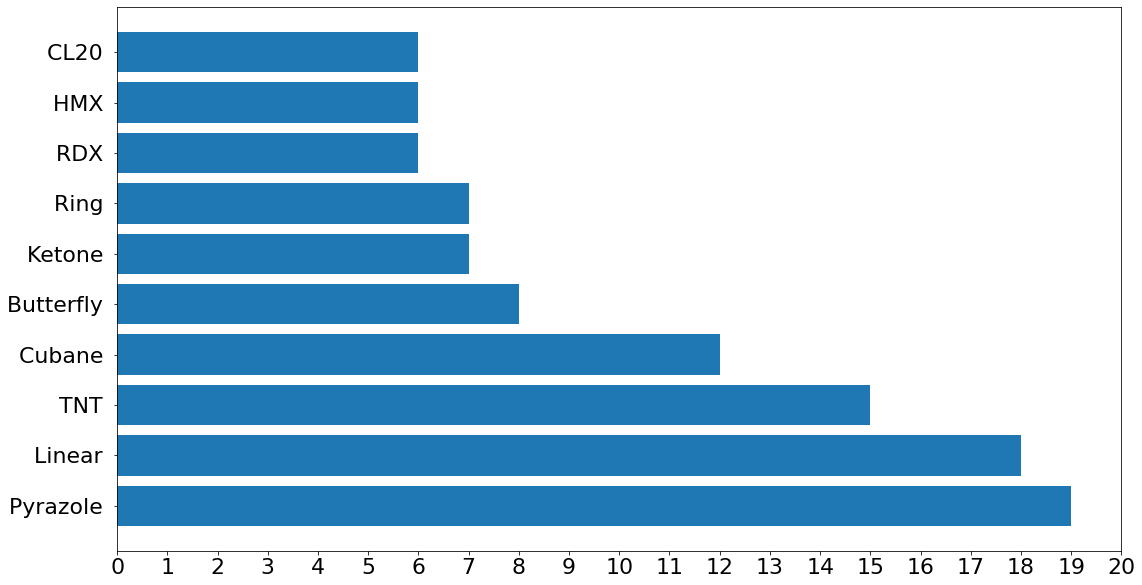

In [22]:
# Matplotlib plotting parameters: figure and font size
plt.rcParams["figure.figsize"] = (18,10)
plt.rcParams['font.size'] = 22

group_counts = df["group"].value_counts()
plt.barh(group_counts.index, group_counts)
plt.xticks(np.arange(0, 21, 1))
plt.show()

Due to this distribution, we can expect that our models will be better classifiers of pyrazole-type compounds than of HMX, CL20 and RDX-type. This could be corrected by adding more examples from the less represented classes.

### Multivariate Plots

Now we can look at the interactions between the variables.

First, let’s look at scatterplots of some pairs of attributes. This can be helpful to spot structured relationships between input variables.

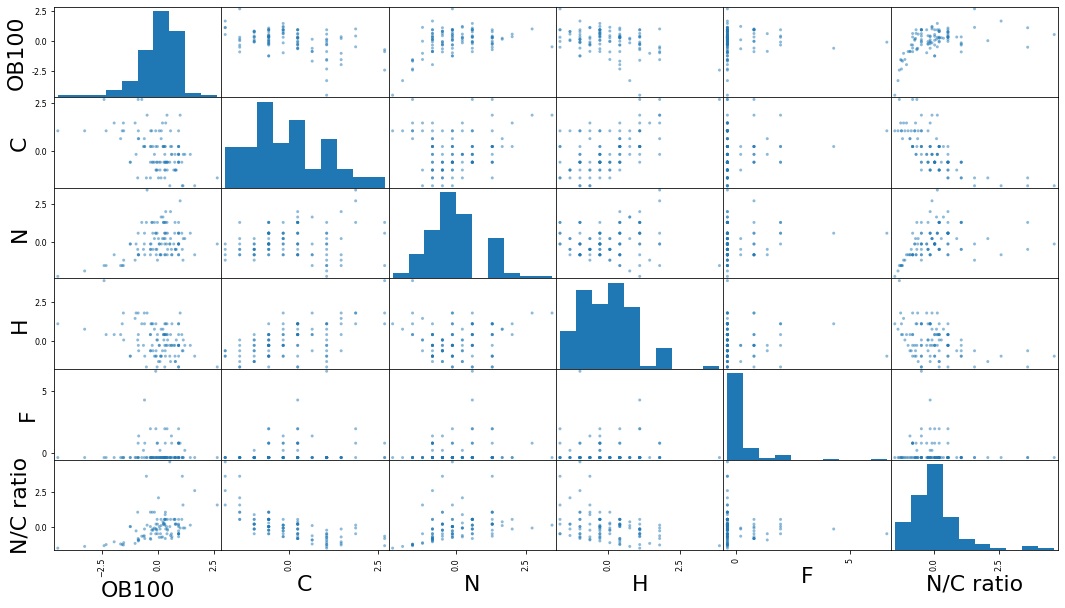

In [23]:
# scatter plot matrix
scatter_df = X[["oxygen_balance_100", "c", "n", "h", "f", "nc_ratio"]]
scatter_df.columns = ["OB100", "C", "N", "H", "F", "N/C ratio"]
scatter_matrix(scatter_df)
plt.show()

It does not look like there are significant correlations between the variables displayed.

We could determine if there is multicollinearity in our dataset by calculating the correlation (R, R²) for all pairs of variables. I will leave this to another notebook.

## Evaluate Some Algorithms

Now, the machine learning part begins. We will:

- Separate out a validation dataset. The validation set, or external test set, will be used to estimate the model accuracy in real life.
- Set-up the test harness to use 10-fold cross validation.
- Build multiple models, compare and select the best model.

In [24]:
# Convert datasets to arrays, to avoid Warnings
X_array = X.values[:, :]
Y_array = Y.to_numpy(dtype=int)

# Split dataset into training and validation
X_train, X_validation, Y_train, Y_validation = train_test_split(X_array, Y_array, test_size=0.20, random_state=1)


Now, we will build models using 7 different algorithms:

- Logistic Regression (LR)
- K-Nearest Neighbors (KNN).
- Gaussian Naive Bayes (NB).
- Support Vector Machines (SVM).
- Linear Discriminant Analysis (LDA)
- Classification and Regression Trees (CART).
- Random forests (RF).

We will use stratified 10-fold cross validation to estimate model accuracy.


In [25]:
# Select Algorithms
models = []
models.append(('LR', LogisticRegression(solver='liblinear')))
    # For small datasets, ‘liblinear’ is a good choice
models.append(('KNN', KNeighborsClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC(gamma='auto')))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('RF', RandomForestClassifier(random_state=1)))

# Evaluate each model with stratified 10-fold cross-validation
results = []
names = []
for name, model in models:
    kfold = StratifiedKFold(n_splits=10, random_state=1, shuffle=True)
    cv_results = cross_val_score(model, X_train, Y_train.ravel(), cv=kfold, scoring='accuracy')
    results.append(cv_results)
    names.append(name)
    print(f'{name}: {cv_results.mean():.2f} ({cv_results.std():.2f})')

LR: 0.81 (0.10)
KNN: 0.75 (0.06)
NB: 0.59 (0.12)
SVM: 0.76 (0.08)
LDA: 0.77 (0.06)
CART: 0.80 (0.13)
RF: 0.79 (0.20)


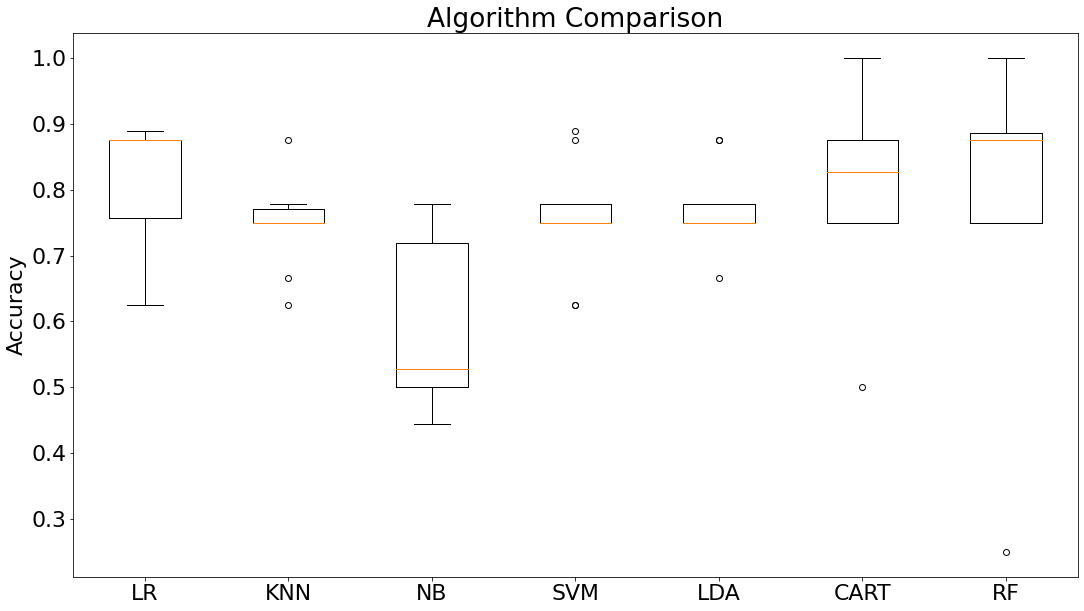

In [26]:
# Compare Algorithms
plt.boxplot(results, labels=names)
plt.title('Algorithm Comparison')
plt.ylabel('Accuracy')
plt.show()

### Validation
Now, we choose the best model to apply on the validation set and try to estimate its true accuracy.

LR, CART and RF scored higher. While CART and RF have a low-accuracy outlier, LR seems more stable.

In [27]:
# Make predictions on validation dataset
model = LogisticRegression(solver='liblinear')
model.fit(X_train, Y_train.ravel())
predictions = model.predict(X_validation)

# Evaluate predictions
print(f"Validation accuracy score: {accuracy_score(Y_validation, predictions):.2f}")
print()
print("Confusion matrix:")
print(confusion_matrix(Y_validation, predictions))
print()
# Confusion matrix: https://en.wikipedia.org/wiki/Confusion_matrix
print("Classification report:")
print(classification_report(Y_validation, predictions))

Validation accuracy score: 0.76

Confusion matrix:
[[11  2]
 [ 3  5]]

Classification report:
              precision    recall  f1-score   support

           0       0.79      0.85      0.81        13
           1       0.71      0.62      0.67         8

    accuracy                           0.76        21
   macro avg       0.75      0.74      0.74        21
weighted avg       0.76      0.76      0.76        21



We can see that even with a model as simple as logistic regression, as well as few descriptors, we were able to achieve a reasonable predictor, with 76% accuracy.

This means that the relative strength of an explosive can, to some extent, be predicted by the chemical features defined.

Let's see if we can learn anything from the misclassified molecules:

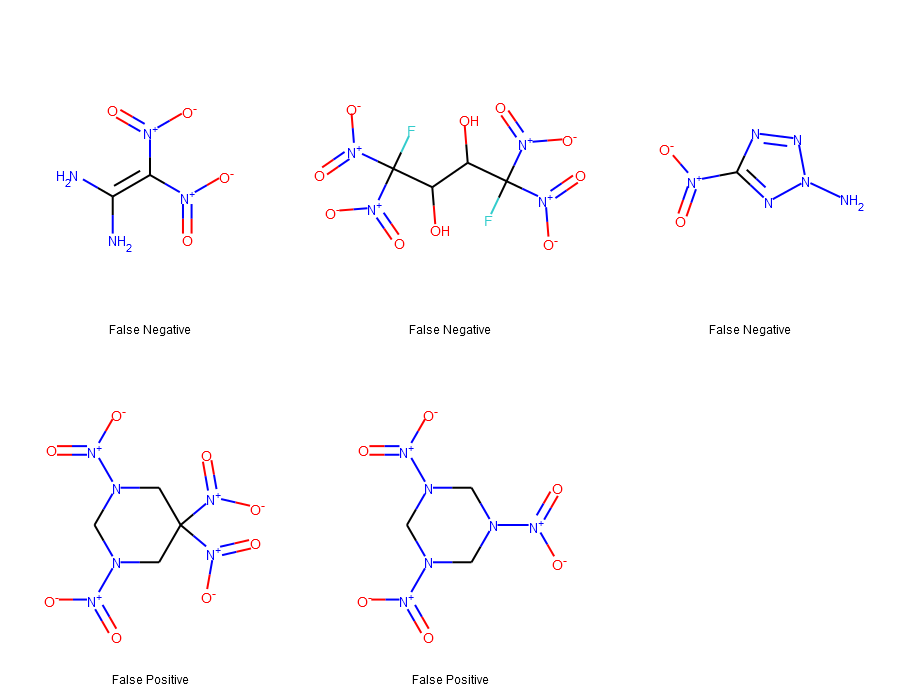

In [28]:
# Finding all false negatives and false positives
fn = []
fp = []
ind = 0
for i in range(len(Y_validation)):
    if Y_validation[i] and (Y_validation[i] != predictions[i]):  # False negative
        fn.append(X_validation[ind])
    elif predictions[i] and (Y_validation[i] != predictions[i]):  # False positive
        fp.append(X_validation[ind])
    ind += 1

# Finding the indexes that correspond to FNs and FPs
indexes = []
for value in fn+fp:
    for index, row in X.iterrows():
        if np.array_equal(value, row):
            indexes.append(index)

# Show structures of misclassified compounds
# Indexes are preserved for every transformation, so indexes in X are the same as in df
ms = []
for i in indexes:
    smi = df['SMILES'].loc[i]  
    ms.append(Chem.MolFromSmiles(smi))

img_legends = len(fn)*['False Negative'] + len(fp)*['False Positive']
img = Chem.Draw.MolsToGridImage(ms, molsPerRow=3, subImgSize=(300, 350), legends=img_legends)
img

The structures don't seem to have anything in common. Let's see to which group they belong:

In [29]:
print(df.iloc[indexes]['group'])

35      Linear 
31      Linear 
46    Pyrazole 
59         RDX 
56         RDX 
Name: group, dtype: object


As stated earlier, we would expect our model to perform worse for RDX, since we have few examples of this class in the dataset. However, Linear and Pyrazole were the groups with the most examples, so maybe the characteristics that define a group are not the same that define explosive strength.

We can verify this:

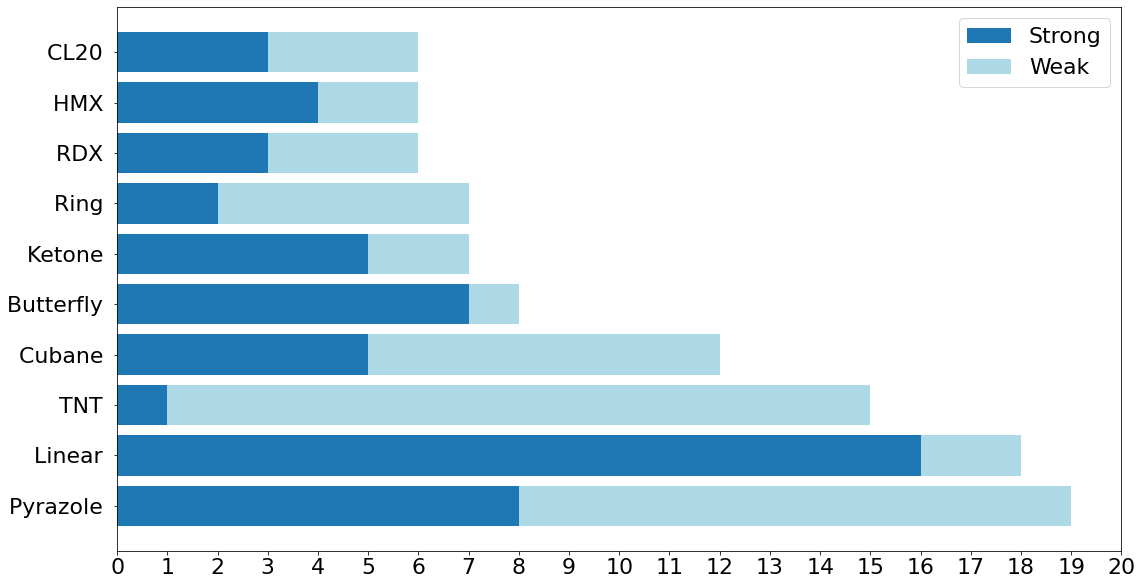

In [30]:
strong_group_counts = dict()
weak_group_counts = dict()

for index in group_counts.index:  # This is to make sure that our bar plot will have the same order as the one above
    strong_group_counts[index] = 0
    weak_group_counts[index] = 0

for i in range(len(Y)):
    group = df.iloc[i]["group"]
    if Y.iloc[i]["Strong_explosive"]:
        if group in strong_group_counts.keys():
            strong_group_counts[group] += 1
        else:
            strong_group_counts[group] = 1
    else:
        if group in weak_group_counts.keys():
            weak_group_counts[group] += 1
        else:
            weak_group_counts[group] = 1 

plt.barh(list(strong_group_counts.keys()), list(strong_group_counts.values()))
plt.barh(list(weak_group_counts.keys()), list(weak_group_counts.values()), 
         left=list(strong_group_counts.values()), color="#add8e6")
plt.legend(labels=["Strong", "Weak"])
plt.xticks(np.arange(0, 21, 1))
plt.show()


Apparently, Linear, Butterfly and Ketone explosives are more likely to be "strong", while TNT and Ring, more likely to be "weak"

Our model was built with several "strong" Linear explosives, therefore, it is not surprising that two of the false positives were Linear: Linear explosives must have features associated with "strong" explosives.

As for Pyrazole and RDX explosives, the distribution of "strong":"weak" in the dataset was close to 50:50, so this analysis doesn't tell us much about why they were misclassified.

However, since the dataset is ordered from stronger to weaker explosive, we can see that the RDX and Pyrazole misclassified explosives are near the middle of the dataset (indexes 46, 56 and 59). This means that their explosive strength is close to our arbitrary boundary of 4 kJ/cc, and it is expected that any model will be better at classifying extremes than compounds near a boundary.

### Next steps

There are several approaches we could take do to make improved models. For example, we could:
1. Add more data
 - This is the main factor that influences machine learning model. If you can, get more (quality) data. The paper cited above used another dataset with more molecules and it is available on the author's GitHub.
 
2. Calculate more descriptors
 - The number of chemical groups we could define is immense. However, having more descriptors can lead to problems if we don't add more data. Dimensionality reduction methods could be applied if we had, for instance, more descriptors than data points.
 - Another way to convert molecules to a machine learning-readable format is using fingerprints. RDKit offers functions to generate several types of fingerprints (MACCS, ECFP, Avalon, E-state, to name a few).
  - The authors of the paper used more elaborate descriptors, besides fingerprints, such as: sum over bonds, Coulomb matrices and Bag of Bonds, some of which performed better than chemical descriptors.
  
3. Use a more complex algorithm
 - This can be effective if you have more data. Examples of algorithms are the different flavors of neural networks. Maybe I will do another notebook with NNs in the future.

### The end!
Below, some tips about saving an ML model and some notes.

#### Save the model
To save the best model to use in the future, we can use the python module pickle.

In [ ]:
import pickle

# save the model to disk
filename = 'final_model.sav'
pickle.dump(model, open(filename, 'wb'))
 
# some time later...
 
# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))


**Important: Tips for Saving Your Model**

This section lists some important considerations when finalizing your machine learning models.

**Python Version**. Take note of the python version. You almost certainly require the same major (and maybe minor) version of Python used to serialize the model when you later load it and deserialize it.

**Library Versions**. The version of all major libraries used in your machine learning project almost certainly need to be the same when deserializing a saved model. This is not limited to the version of NumPy and the version of scikit-learn.

**Manual Serialization**. You might like to manually output the parameters of your learned model so that you can use them directly in scikit-learn or another platform in the future. Often the algorithms used by machine learning algorithms to make predictions are a lot simpler than those used to learn the parameters can may be easy to implement in custom code that you have control over.

Take note of the version so that you can re-create the environment if for some reason you cannot reload your model on another machine or another platform at a later time.

In [ ]:
# Note: for molecules with >1000 atoms, my count method could yield incorrect values
# See: https://sourceforge.net/p/rdkit/mailman/rdkit-discuss/thread/CAFdOP2uSPZv6wgNY9ZRumLB%2Bwxxu%2BLpMyTs8sC_kbn0Pr5YxEw%40mail.gmail.com/#msg34524687
# Suggestions for datasets with larger molecules:

pat = Chem.MolFromSmarts("[#6]")
def count3(mol):
    return len(mol.GetSubstructMatches(pat, maxMatches=mol.GetNumAtoms()))

from rdkit.Chem import rdqueries
q = rdqueries.AtomNumEqualsQueryAtom(6)
len(mol.GetAtomsMatchingQuery(q))

In [ ]:
# Drawing in RDKit
Chem.Draw.MolsToGridImage(subImgSize=(300, 350)) # looks nice for 3 molecules per row

In [ ]:
# Class Distribution merging the X and Y datasets
merged = pd.concat([X, Y], axis=1)
print(merged.groupby('Strong_explosive').size())